### Bank marketing campaigns dataset analysis
Predict if a customer will respond to market campaigns for TMD. The problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy ((TP+TN)/total) is not a useful metric when dealing with an imbalanced problem.

If there are lots of samples that are "negative" relative to the number positive samples, then precision (TP/(TP+FP)) might be more useful than False Positive Rate because Precision does not include True Negative in this calculation, and is not affected by the imbalance. 

- True Positive Rate = TP/actual positive, also called "Sensitivity" or "Recall".<br>
- True Negative Rate = TN/actual negative = 1 - False Positive Rate (FP/actual no), also called "Specificity"<br>
- False Positive Rate = 1 - Specificity
- Precision = TP/(TP+FP)

In this project, classification will be done by different algorithms. The performance of these algorithms will be compared so as to pick the best model.

#### Data: 
The dataset is public available for research. The details are described in S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

##### References from Kaggle:
https://www.kaggle.com/volodymyrgavrysh/bank-marketing-campaigns-dataset<br>
https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

##### Skills: 
Histogram, pd.crosstab, Pearson’s Chi-Squared Test, Confusion Matrix, Decision Tree, Random Forest, Optimized Random Rorest and tensorflow <br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
# renaming and deprecation of cross_validation sub-module to model_selection.
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import shutil
import glob
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# from show_confusion_matrix import show_confusion_matrix 
# the above is from http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
print(tf.__version__)

1.15.0


### 2. Read data file and create datasets

In [2]:
df = pd.read_csv("bank-full.csv",sep=';')
df.drop(columns=['balance'],inplace=True)
print(df.shape)
df.head()

(45211, 16)


age           job  marital  education default housing loan  contact  day  \
0   58    management  married   tertiary      no     yes   no  unknown    5   
1   44    technician   single  secondary      no     yes   no  unknown    5   
2   33  entrepreneur  married  secondary      no     yes  yes  unknown    5   
3   47   blue-collar  married    unknown      no     yes   no  unknown    5   
4   33       unknown   single    unknown      no      no   no  unknown    5   

  month  duration  campaign  pdays  previous poutcome   y  
0   may       261         1     -1         0  unknown  no  
1   may       151         1     -1         0  unknown  no  
2   may        76         1     -1         0  unknown  no  
3   may        92         1     -1         0  unknown  no  
4   may       198         1     -1         0  unknown  no

In [1]:
"""
# Bucketize Age. But it appears that the correlation is relatively high. 
from sklearn.preprocessing import KBinsDiscretizer

Xt = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(df[['age']])
#print(df['age'].head(20), Xt[0:20])
Xt.shape
Xt = np.reshape(Xt, (45211, )).astype(int).astype(str)
Xt = pd.Series(Xt)
Xt
"""

"\n# Bucketize Age. But it appears that the correlation is relatively high. \nfrom sklearn.preprocessing import KBinsDiscretizer\n\nXt = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(df[['age']])\n#print(df['age'].head(20), Xt[0:20])\nXt.shape\nXt = np.reshape(Xt, (45211, )).astype(int).astype(str)\nXt = pd.Series(Xt)\nXt\n"

In [3]:
#df['month'].unique()
#df[df['month']=='feb']['day'].value_counts()
df.loc[df['default']=='yes','default'] = 1
df.loc[df['default']=='no','default'] = 0
df.loc[df['housing']=='yes','housing'] = 1
df.loc[df['housing']=='no','housing'] = 0
df.loc[df['loan']=='yes','loan'] = 1
df.loc[df['loan']=='no','loan'] = 0
df.loc[df['y']=='yes','y'] = 1
df.loc[df['y']=='no','y'] = 0

df.rename(columns={"day": "dayofmonth", "y": "subscribe"}, inplace=True)
df.head()

age           job  marital  education  default  housing  loan  contact  \
0   58    management  married   tertiary        0        1     0  unknown   
1   44    technician   single  secondary        0        1     0  unknown   
2   33  entrepreneur  married  secondary        0        1     1  unknown   
3   47   blue-collar  married    unknown        0        1     0  unknown   
4   33       unknown   single    unknown        0        0     0  unknown   

   dayofmonth month  duration  campaign  pdays  previous poutcome  subscribe  
0           5   may       261         1     -1         0  unknown          0  
1           5   may       151         1     -1         0  unknown          0  
2           5   may        76         1     -1         0  unknown          0  
3           5   may        92         1     -1         0  unknown          0  
4           5   may       198         1     -1         0  unknown          0

### 3. Analyze the data for data engineering

In [4]:
print(df.describe())
print(df.dtypes)
df['subscribe'].value_counts()

                age       default       housing          loan    dayofmonth  \
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210      0.018027      0.555838      0.160226     15.806419   
std       10.618762      0.133049      0.496878      0.366820      8.322476   
min       18.000000      0.000000      0.000000      0.000000      1.000000   
25%       33.000000      0.000000      0.000000      0.000000      8.000000   
50%       39.000000      0.000000      1.000000      0.000000     16.000000   
75%       48.000000      0.000000      1.000000      0.000000     21.000000   
max       95.000000      1.000000      1.000000      1.000000     31.000000   

           duration      campaign         pdays      previous     subscribe  
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000  
mean     258.163080      2.763841     40.197828      0.580323      0.116985  
std      257.527812      3.098021    100.128746      2

0    39922
1     5289
Name: subscribe, dtype: int64

### 4. Data analysis

age           0.025155
dayofmonth   -0.028348
duration      0.394521
campaign     -0.073172
pdays         0.103621
dtype: float64


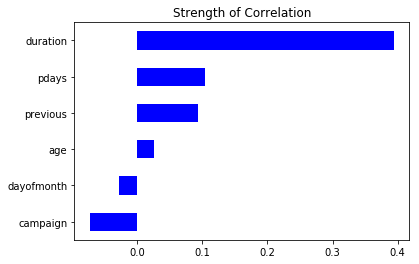

In [5]:
numeric = df[['age','dayofmonth','duration','campaign','pdays','previous']]
corr = numeric.corrwith(df['subscribe'])
print(corr.head())
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

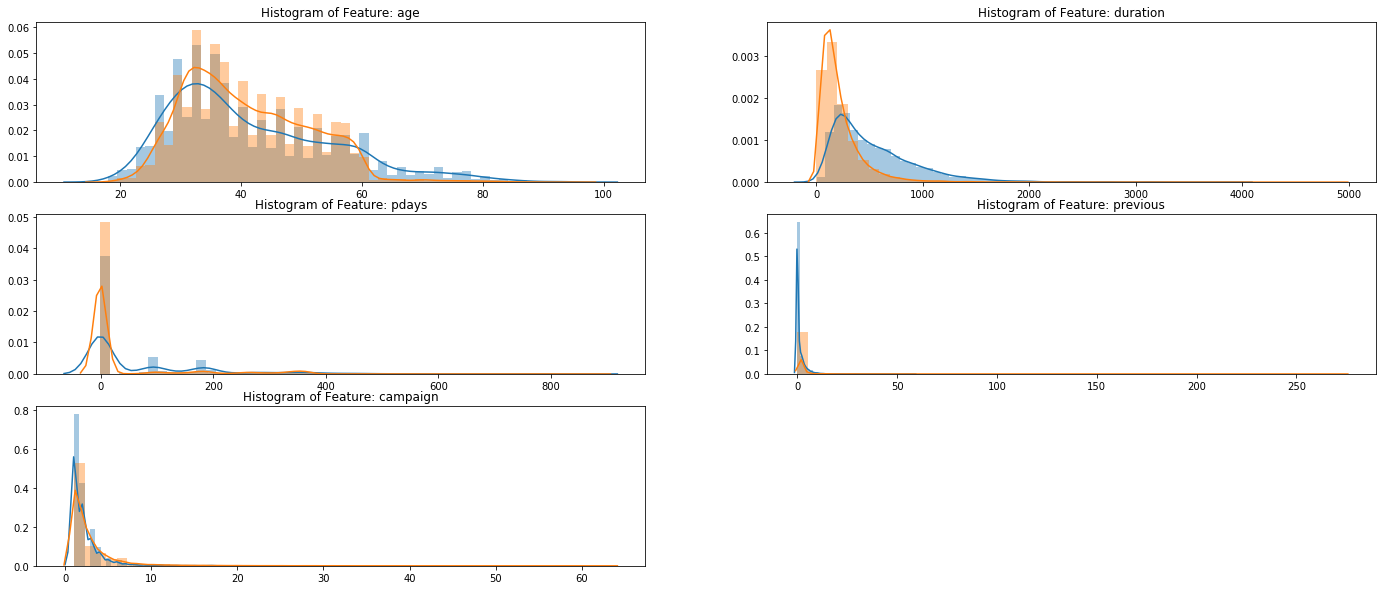

In [6]:
features = ['age','duration','pdays','previous','campaign']
plt.figure(figsize=(24,10))
gs = gridspec.GridSpec(3, 2)
for i, ft in enumerate(features):
    ax = plt.subplot(gs[i])
    # Blue
    sns.distplot(df[ft][df.subscribe == 1], bins=50)
    # Orange
    sns.distplot(df[ft][df.subscribe == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Histogram of Feature: ' + str(ft))
plt.show()

The Chi-Squared test is a statistical hypothesis test that assumes (the null hypothesis) that the observed frequencies for a categorical variable match the expected frequencies for the categorical variable. The test calculates a statistic that has a chi-squared distribution, named for the Greek capital letter Chi (X) pronounced “ki” as in kite.

The result of the test is a test statistic that has a chi-squared distribution and can be interpreted to reject or fail to reject the assumption or null hypothesis that the observed and expected frequencies are the same.

In [7]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [8]:
df[df['subscribe']==0]['poutcome'].value_counts()

unknown    33573
failure     4283
other       1533
success      533
Name: poutcome, dtype: int64

In [9]:
#cross_table = pd.crosstab(df['subscribe'],df['marital'],margins=True)
#print(cross_table)

marital    divorced  married  single    All
subscribe                                  
0              4585    24459   10878  39922
1               622     2755    1912   5289
All            5207    27214   12790  45211
[4585  622 5207]
[4585  622]
[4585  622 5207]


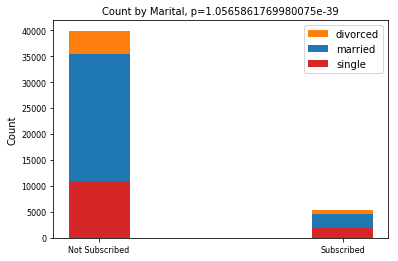

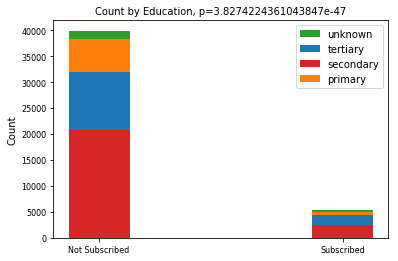

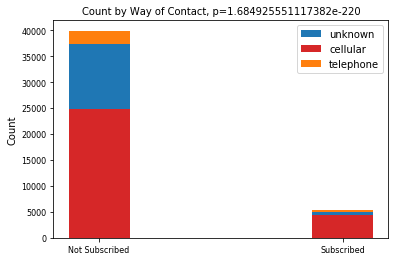

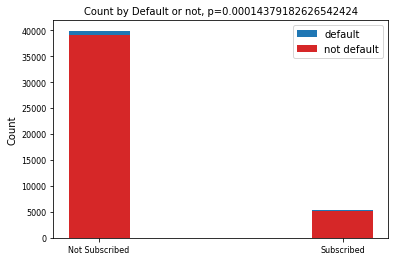

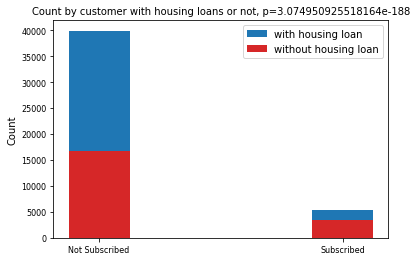

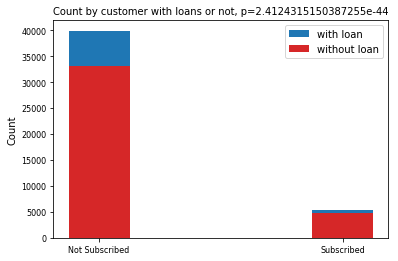

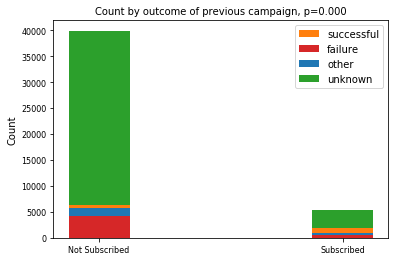

In [8]:
categories = ["Not Subscribed","Subscribed"]

# Marital
cross_table = pd.crosstab(df['subscribe'],df['marital'],margins=True)
divorcedcount = cross_table['divorced'][0:cross_table.shape[0]-1].values
marriedcount = cross_table['married'][0:cross_table.shape[0]-1].values
singlecount = cross_table['single'][0:cross_table.shape[0]-1].values
stat, p, dof, expected = chi2_contingency(cross_table)

p1 = plt.bar(categories, singlecount, 0.25, color='#d62728',)
p2 = plt.bar(categories, marriedcount, 0.25, bottom=singlecount)
p3 = plt.bar(categories, divorcedcount, 0.25, bottom=singlecount+marriedcount)
plt.legend((p3[0], p2[0], p1[0]), ('divorced', 'married', 'single'), fontsize=10)
plt.ylabel("Count")
plt.title('Count by Marital, p={}'.format(p))
#lt.title('Count by Marital, p={0:.2f}'.format(p))
plt.show()

# Education
cross_table = pd.crosstab(df['subscribe'],df['education'],margins=True)
pricount = cross_table['primary'][0:cross_table.shape[0]-1].values
seccount = cross_table['secondary'][0:cross_table.shape[0]-1].values
tercount = cross_table['tertiary'][0:cross_table.shape[0]-1].values
unkcount = cross_table['unknown'][0:cross_table.shape[0]-1].values
stat, p, dof, expected = chi2_contingency(cross_table)

p1 = plt.bar(categories, seccount, 0.25, color='#d62728',)
p2 = plt.bar(categories, tercount, 0.25, bottom=seccount)
p3 = plt.bar(categories, pricount, 0.25, bottom=seccount+tercount)
p4 = plt.bar(categories, unkcount, 0.25, bottom=seccount+tercount+pricount)
plt.legend((p4[0], p2[0], p1[0], p3[0]), ('unknown', 'tertiary', 'secondary', 'primary'), fontsize=10)
plt.ylabel("Count")
plt.title('Count by Education, p={}'.format(p))
plt.show()

# Contact
cross_table = pd.crosstab(df['subscribe'],df['contact'],margins=True)
cellcount = cross_table['cellular'][0:cross_table.shape[0]-1].values
telcount = cross_table['telephone'][0:cross_table.shape[0]-1].values
unkcount = cross_table['unknown'][0:cross_table.shape[0]-1].values
stat, p, dof, expected = chi2_contingency(cross_table)

p1 = plt.bar(categories, cellcount, 0.25, color='#d62728',)
p2 = plt.bar(categories, unkcount, 0.25, bottom=cellcount)
p3 = plt.bar(categories, telcount, 0.25, bottom=cellcount+unkcount)
plt.legend((p2[0], p1[0], p3[0]), ('unknown', 'cellular', 'telephone'), fontsize=10)
plt.ylabel("Count")
plt.title('Count by Way of Contact, p={}'.format(p))
plt.show()

# Default
cross_table = pd.crosstab(df['subscribe'],df['default'],margins=True)
notdefcount = cross_table[0][0:cross_table.shape[0]-1].values
defcount = cross_table[1][0:cross_table.shape[0]-1].values
stat, p, dof, expected = chi2_contingency(cross_table)

p1 = plt.bar(categories, notdefcount, 0.25, color='#d62728',)
p2 = plt.bar(categories, defcount, 0.25, bottom=notdefcount)
plt.legend((p2[0], p1[0]), ('default', 'not default'), fontsize=10)
plt.ylabel("Count")
plt.title('Count by Default or not, p={}'.format(p))
plt.show()

# Housing
cross_table = pd.crosstab(df['subscribe'],df['housing'],margins=True)
nohousecount = cross_table[0][0:cross_table.shape[0]-1].values
housecount = cross_table[1][0:cross_table.shape[0]-1].values
stat, p, dof, expected = chi2_contingency(cross_table)

p1 = plt.bar(categories, nohousecount, 0.25, color='#d62728',)
p2 = plt.bar(categories, housecount, 0.25, bottom=nohousecount)
plt.legend((p2[0], p1[0]), ('with housing loan', 'without housing loan'), fontsize=10)
plt.ylabel("Count")
plt.title('Count by customer with housing loans or not, p={}'.format(p))
plt.show()

# Loan
cross_table = pd.crosstab(df['subscribe'],df['loan'],margins=True)
noloancount = cross_table[0][0:cross_table.shape[0]-1].values
loancount = cross_table[1][0:cross_table.shape[0]-1].values
stat, p, dof, expected = chi2_contingency(cross_table)

p1 = plt.bar(categories, noloancount, 0.25, color='#d62728',)
p2 = plt.bar(categories, loancount, 0.25, bottom=noloancount)
plt.legend((p2[0], p1[0], p3[0]), ('with loan', 'without loan'), fontsize=10)
plt.ylabel("Count")
plt.title('Count by customer with loans or not, p={}'.format(p))
plt.show()

# poutcome
cross_table = pd.crosstab(df['subscribe'],df['poutcome'],margins=True)
failcount = cross_table['failure'][0:cross_table.shape[0]-1].values
othercount = cross_table['other'][0:cross_table.shape[0]-1].values
succount = cross_table['success'][0:cross_table.shape[0]-1].values
unkcount = cross_table['unknown'][0:cross_table.shape[0]-1].values
stat, p, dof, expected = chi2_contingency(cross_table)

p1 = plt.bar(categories, failcount, 0.25, color='#d62728',)
p2 = plt.bar(categories, othercount, 0.25, bottom=failcount)
p3 = plt.bar(categories, succount, 0.25, bottom=failcount+othercount)
p4 = plt.bar(categories, unkcount, 0.25, bottom=failcount+othercount+succount)
plt.legend((p3[0], p1[0], p2[0], p4[0]), ('successful', 'failure','other', 'unknown'), fontsize=10)
plt.ylabel("Count")
plt.title('Count by outcome of previous campaign, p={0:.3f}'.format(p))
plt.show()

From the above analysis, all the data points except age can be selected as features. Simple feature engineering is required.<br>

In [9]:
# cannot do ohe to numeric, so change the data type of dayofmonth to string first
df['dayofmonth'] = df['dayofmonth'].astype("str")
ohe = pd.get_dummies(df[['job','marital','education','contact','dayofmonth','month','poutcome']])
print(ohe.head())

   job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0           0                0                 0              0   
1           0                0                 0              0   
2           0                0                 1              0   
3           0                1                 0              0   
4           0                0                 0              0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0               1            0                  0             0            0   
1               0            0                  0             0            0   
2               0            0                  0             0            0   
3               0            0                  0             0            0   
4               0            0                  0             0            0   

   job_technician  ...  month_jun  month_mar  month_may  month_nov  month_oct  \
0               0  ...          0  

In [10]:
# leave df unchanged (except day of month) first for Tensorflow.
temp = pd.concat([df[['default','housing','loan','duration','campaign','pdays','previous']],ohe,df['subscribe']],axis=1)
feature_list = temp.columns[0:-1].tolist()
print(feature_list)
print('number of features: ', len(feature_list))

['default', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'dayofmonth_1', 'dayofmonth_10', 'dayofmonth_11', 'dayofmonth_12', 'dayofmonth_13', 'dayofmonth_14', 'dayofmonth_15', 'dayofmonth_16', 'dayofmonth_17', 'dayofmonth_18', 'dayofmonth_19', 'dayofmonth_2', 'dayofmonth_20', 'dayofmonth_21', 'dayofmonth_22', 'dayofmonth_23', 'dayofmonth_24', 'dayofmonth_25', 'dayofmonth_26', 'dayofmonth_27', 'dayofmonth_28', 'dayofmonth_29', 'dayofmonth_3', 'dayofmonth_30', 'dayofmonth_31', 'dayofmonth_4', 'dayofmonth_5', 'dayofmonth_6', 'dayofmonth_7', 'dayofmonth_8', 'dayofmonth_

### A. Decision Tree
#### A1. Creating Datasets
Data engineering for Sci-kit Learn's purpose

In [11]:
msk = np.random.rand(len(temp)) < 0.7
traindf = temp[msk]
restdf = temp[~msk]
restdf.reset_index(drop=True)
msk = np.random.rand(len(restdf)) < 0.8
evaldf = restdf[msk]
testdf = restdf[~msk]
print("Training Dataset: {}, Validation Dataset: {}, Testing Dataset: {}".format(traindf.shape, evaldf.shape, testdf.shape))

Training Dataset: (31700, 77), Validation Dataset: (10859, 77), Testing Dataset: (2652, 77)


Save to csv files for future use

In [12]:
#traindf.drop(traindf.columns[0], axis=1)
traindf.to_csv("traindf.csv",index=False)
evaldf.to_csv("evaldf.csv",index=False)
testdf.to_csv("testdf.csv",index=False)

#### A2. Modeling

In [13]:
RSEED = 50
tree = DecisionTreeClassifier(max_depth = 10, random_state=RSEED)
tree.fit(traindf.iloc[:,0:-1], traindf['subscribe'])
print('Model Accuracy: {}'.format(tree.score(traindf.iloc[:,0:-1], traindf['subscribe'])))

Model Accuracy: 0.9228706624605678


Due to the inbalanced data, accuracy is not a good measurement

In [14]:
# Export as dot
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = feature_list, 
                class_names = ['0', '1'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=400']);

# Visualize
Image('tree.png')

#### A3. Assess Decision Tree Performance

In [15]:
# Make probability predictions. This gives you the probability of being class "1". 
train_probs = tree.predict_proba(traindf.iloc[:,0:-1])[:, 1]
eval_probs = tree.predict_proba(evaldf.iloc[:,0:-1])[:, 1]
test_probs = tree.predict_proba(testdf.iloc[:,0:-1])[:, 1]

# using predict, you already decide the threshold
train_predictions = tree.predict(traindf.iloc[:,0:-1])
eval_predictions = tree.predict(evaldf.iloc[:,0:-1])
test_predictions = tree.predict(testdf.iloc[:,0:-1])

In [16]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

#area under the curve of a ROC curve
print('Train ROC AUC Score: {}'.format(roc_auc_score(traindf['subscribe'], train_probs)))
print('Validation ROC AUC Score: {}'.format(roc_auc_score(evaldf['subscribe'], eval_probs)))
print('Test ROC AUC Score: {}'.format(roc_auc_score(testdf['subscribe'], test_probs)))

Train ROC AUC Score: 0.9215831777179055
Validation ROC AUC Score: 0.848580541673173
Test ROC AUC Score: 0.8374014811230586


#### A4. Evaluate the Decision Tree
We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top.

In [17]:
def evaluate_model(eval_predictions, eval_probs, train_predictions, train_probs, test_predictions, test_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
     
    baseline = {}
    #no brainer prediction
    baseline['recall'] = recall_score(evaldf['subscribe'], [1 for _ in range(len(evaldf['subscribe']))])
    baseline['precision'] = precision_score(evaldf['subscribe'], [1 for _ in range(len(evaldf['subscribe']))])
    baseline['roc'] = 0.5
    
    eval_results = {}
    eval_results['recall'] = recall_score(evaldf['subscribe'], eval_predictions)
    eval_results['precision'] = precision_score(evaldf['subscribe'], eval_predictions)
    eval_results['roc'] = roc_auc_score(evaldf['subscribe'], eval_probs)
    
    train_results = {}
    train_results['recall'] = recall_score(traindf['subscribe'], train_predictions)
    train_results['precision'] = precision_score(traindf['subscribe'], train_predictions)
    train_results['roc'] = roc_auc_score(traindf['subscribe'], train_probs)

    test_results = {}
    test_results['recall'] = recall_score(testdf['subscribe'], test_predictions)
    test_results['precision'] = precision_score(testdf['subscribe'], test_predictions)
    test_results['roc'] = roc_auc_score(testdf['subscribe'], test_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print("{0} - Baseline: {1:.2f} Training: {2:.2f} Validation: {3:.2f} Test: {4:.2f}".format(metric.capitalize(), baseline[metric], train_results[metric], eval_results[metric], test_results[metric]))
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(evaldf['subscribe'], [1 for _ in range(len(evaldf['subscribe']))])
    train_fpr, train_tpr, _ = roc_curve(traindf['subscribe'], train_probs)
    eval_fpr, eval_tpr, _ = roc_curve(evaldf['subscribe'], eval_probs)
    test_fpr, test_tpr, _ = roc_curve(testdf['subscribe'], test_probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    print("\n")
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(train_fpr, train_tpr, 'g', label = 'train')
    plt.plot(eval_fpr, eval_tpr, 'r', label = 'model (validation data)')
    plt.plot(test_fpr, test_tpr, 'b', label = 'model (test data)', color="purple")

    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    
    return pd.DataFrame(data=list(test_results.values())).T

In [20]:
"""
from collections import Counter
print(Counter(test_probs))
print(Counter(test_predictions))
"""

'\nfrom collections import Counter\nprint(Counter(test_probs))\nprint(Counter(test_predictions))\n'

##### Store the results of all the algorithms

Recall - Baseline: 1.00 Training: 0.50 Validation: 0.41 Test: 0.38
Precision - Baseline: 0.12 Training: 0.75 Validation: 0.61 Test: 0.59
Roc - Baseline: 0.50 Training: 0.92 Validation: 0.85 Test: 0.84




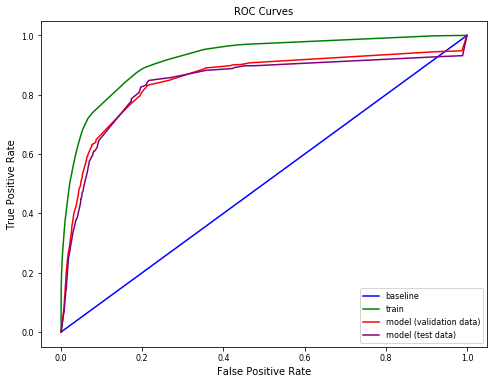

In [18]:
output = pd.DataFrame()
output = output.append(evaluate_model(eval_predictions, eval_probs, train_predictions, train_probs, test_predictions, test_probs))

#### A5. Confusion Matrix

In [19]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 18)
    plt.colorbar(aspect=2)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[2244   85]
 [ 201  122]]


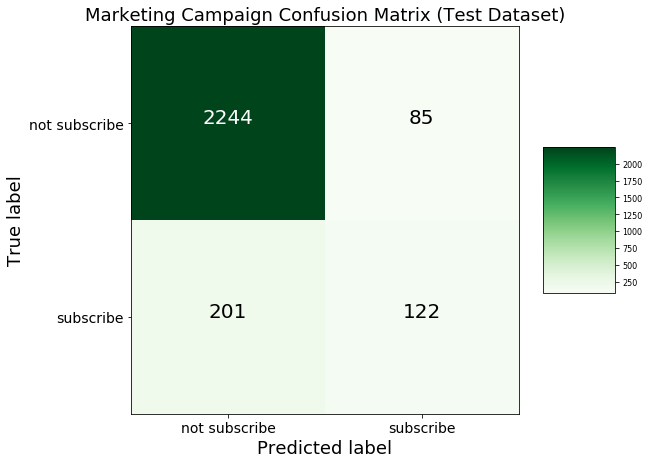

In [20]:
cm = confusion_matrix(testdf['subscribe'], test_predictions)
plot_confusion_matrix(cm, classes = ['not subscribe', 'subscribe'], title = 'Marketing Campaign Confusion Matrix (Test Dataset)')

#### A6. Feature Importance
Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used.

In [21]:
importance = pd.DataFrame({'feature': feature_list,'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
importance.head()

feature  importance
3           duration    0.407726
74  poutcome_success    0.212186
5              pdays    0.056985
1            housing    0.042735
67         month_mar    0.029671

### B. Random Forest
#### B1. Modeling
No need to make any changes to the dataset

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
forest = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
forest.fit(traindf.iloc[:,0:-1], traindf['subscribe'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [23]:
n_nodes = []
max_depths = []

for ind_tree in forest.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print('Average number of nodes {}'.format(int(np.mean(n_nodes))))
print('Average maximum depth {}'.format(int(np.mean(max_depths))))

Average number of nodes 7995
Average maximum depth 46


#### B2. Random Forest Results

In [24]:
train_rf_probs = forest.predict_proba(traindf.iloc[:,0:-1])[:, 1]
eval_rf_probs = forest.predict_proba(evaldf.iloc[:,0:-1])[:, 1]
test_rf_probs = forest.predict_proba(testdf.iloc[:,0:-1])[:, 1]

train_rf_predictions = forest.predict(traindf.iloc[:,0:-1])
eval_rf_predictions = forest.predict(evaldf.iloc[:,0:-1])
test_rf_predictions = forest.predict(testdf.iloc[:,0:-1])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_job

Recall - Baseline: 1.00 Training: 1.00 Validation: 0.40 Test: 0.41
Precision - Baseline: 0.12 Training: 1.00 Validation: 0.66 Test: 0.65
Roc - Baseline: 0.50 Training: 1.00 Validation: 0.92 Test: 0.93




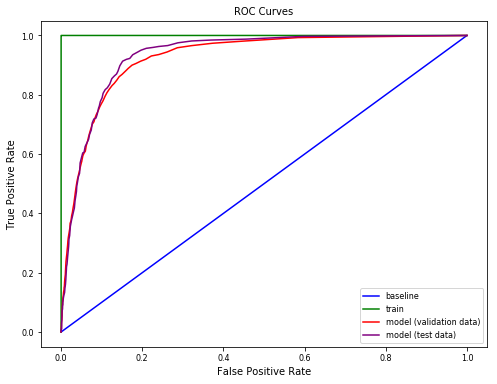

In [25]:
output = output.append(evaluate_model(eval_rf_predictions, eval_rf_probs, train_rf_predictions, train_rf_probs, test_rf_predictions, test_rf_probs))

#### B3. Confusion Matrix

Confusion matrix, without normalization
[[2258   71]
 [ 192  131]]


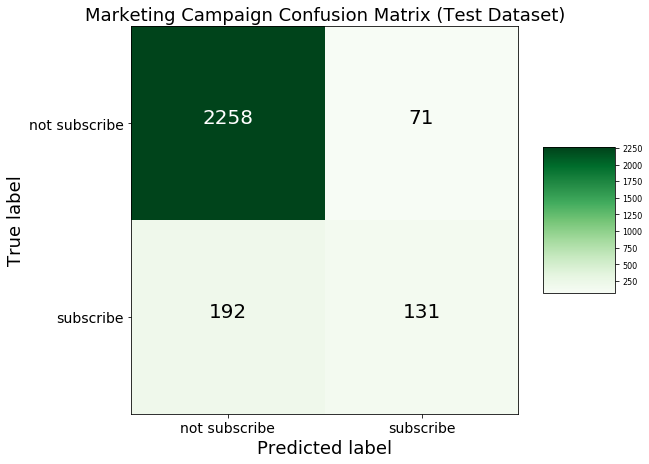

In [26]:
cm = confusion_matrix(testdf['subscribe'], test_rf_predictions)
plot_confusion_matrix(cm, classes = ['not subscribe', 'subscribe'], title = 'Marketing Campaign Confusion Matrix (Test Dataset)')

Compared to the single decision tree, the model has fewer false postives but more false negatives. 

#### B4. Feature Importance

In [27]:
rf_importance = pd.DataFrame({'feature': feature_list,'importance': forest.feature_importances_}).sort_values('importance', ascending = False)
rf_importance.head(5)

feature  importance
3           duration    0.300345
4           campaign    0.050794
5              pdays    0.042651
74  poutcome_success    0.041987
1            housing    0.023656

### C. Random Forest Optimization through Random Search
#### C1. Modeling
In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best.

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(traindf.iloc[:,0:-1], traindf['subscribe'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Parameters for the best model

In [29]:
rs.best_params_

{'bootstrap': True,
 'max_depth': 16,
 'max_features': 0.7999999999999999,
 'max_leaf_nodes': 11,
 'min_samples_split': 5,
 'n_estimators': 25}

#### C2. Using the Best Hyperparameter Values
We can see that the best hyperparameter values are not the defaults. This shows the importance of tuning a model for a specific dataset. Each dataset will have different characteristics, and the model that does best on one dataset will not necessarily do the best across all datasets. Now we can take the best model (it has already been trained) and evaluate it. Hopefully it does better than the stock Random Forest.

In [30]:
best_model = rs.best_estimator_

In [31]:
train_rf_predictions = best_model.predict(traindf.iloc[:,0:-1])
eval_rf_predictions = best_model.predict(evaldf.iloc[:,0:-1])
test_rf_predictions = best_model.predict(testdf.iloc[:,0:-1])

train_rf_probs = best_model.predict_proba(traindf.iloc[:,0:-1])[:, 1]
eval_rf_probs = best_model.predict_proba(evaldf.iloc[:,0:-1])[:, 1]
test_rf_probs = best_model.predict_proba(testdf.iloc[:,0:-1])[:, 1]

In [32]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print('Average number of nodes {}'.format(int(np.mean(n_nodes))))
print('Average maximum depth {}'.format(int(np.mean(max_depths))))

Average number of nodes 21
Average maximum depth 6


Recall - Baseline: 1.00 Training: 0.37 Validation: 0.34 Test: 0.35
Precision - Baseline: 0.12 Training: 0.64 Validation: 0.65 Test: 0.61
Roc - Baseline: 0.50 Training: 0.89 Validation: 0.89 Test: 0.89




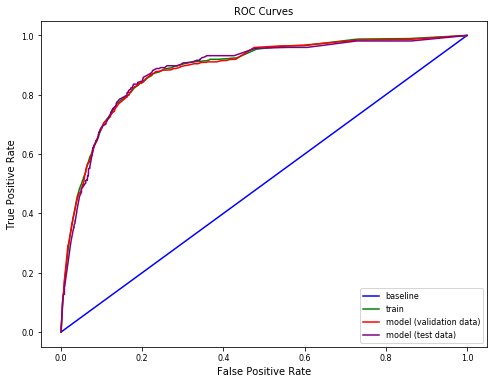

In [33]:
output = output.append(evaluate_model(eval_rf_predictions, eval_rf_probs, train_rf_predictions, train_rf_probs, test_rf_predictions, test_rf_probs))
output.index = ['Decision Tree', 'Random Forest','Optimized Randome Forest']
output.columns = ['ROC','Precision','Recall']

#### C3. Visualize the Optimized Decision Tree

In [34]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=feature_list, max_depth = 6, 
                class_names = ['not subscribe', 'subscribe'], filled = True)

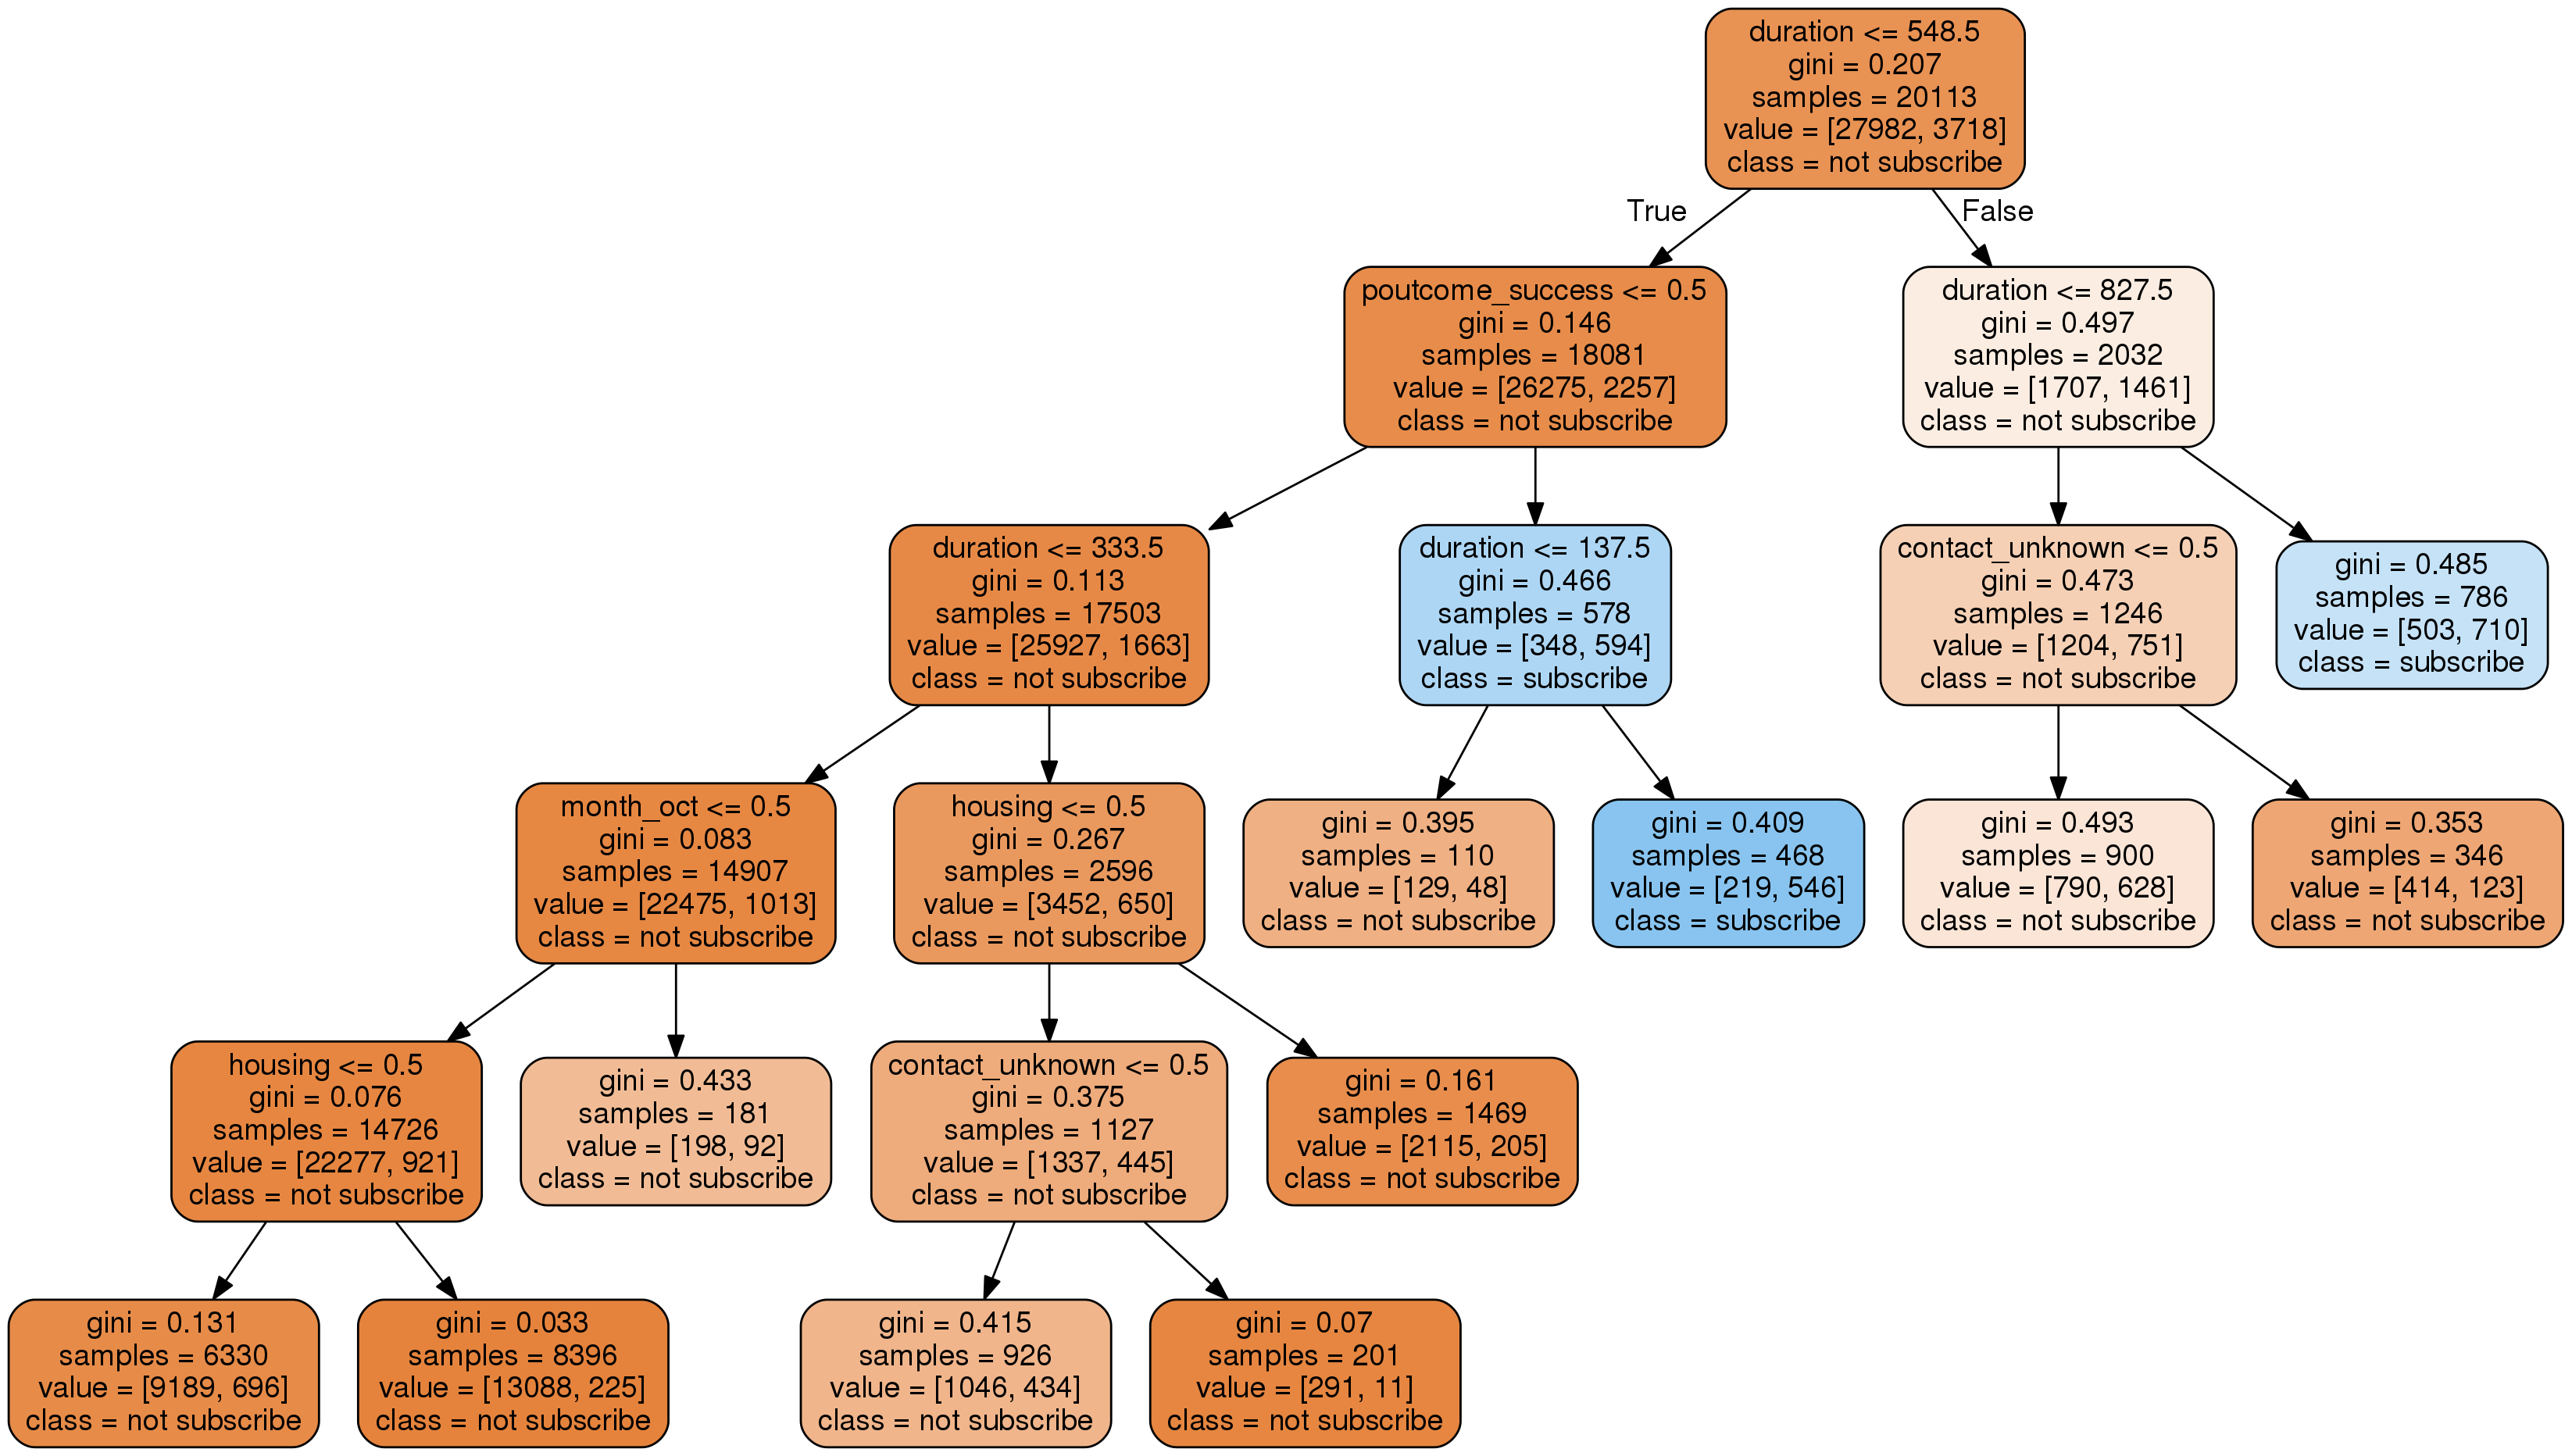

In [35]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

### D. Tensorflow
#### D1. Read Datasets by Input Functions
Need to create data in Tensorflow, so use the df dataframe

In [74]:
"""
print(traindf[['default', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous']].dtypes)
traindf[[col for col in traindf.columns[traindf.columns.str.contains('job')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('job')]]].astype(int)
traindf[[col for col in traindf.columns[traindf.columns.str.contains('marital')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('marital')]]].astype(int)
traindf[[col for col in traindf.columns[traindf.columns.str.contains('education')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('education')]]].astype(int)
traindf[[col for col in traindf.columns[traindf.columns.str.contains('contact')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('contact')]]].astype(int)
traindf[[col for col in traindf.columns[traindf.columns.str.contains('month')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('month')]]].astype(int)
traindf[[col for col in traindf.columns[traindf.columns.str.contains('outcome')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('outcome')]]].astype(int)
print(traindf[[col for col in traindf.columns[traindf.columns.str.contains('job')]]].dtypes)
"""

"\nprint(traindf[['default', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous']].dtypes)\ntraindf[[col for col in traindf.columns[traindf.columns.str.contains('job')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('job')]]].astype(int)\ntraindf[[col for col in traindf.columns[traindf.columns.str.contains('marital')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('marital')]]].astype(int)\ntraindf[[col for col in traindf.columns[traindf.columns.str.contains('education')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('education')]]].astype(int)\ntraindf[[col for col in traindf.columns[traindf.columns.str.contains('contact')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('contact')]]].astype(int)\ntraindf[[col for col in traindf.columns[traindf.columns.str.contains('month')]]] = traindf[[col for col in traindf.columns[traindf.columns.str.contains('month')]]].astype(int)\n

In [36]:
# run the following if this has not been run before
df['dayofmonth'] = df['dayofmonth'].astype("str")

msk = np.random.rand(len(df)) < 0.7
train = df[msk].drop(['age'], axis=1)
restdf = df[~msk].drop(['age'], axis=1)
restdf.reset_index(drop=True)
msk = np.random.rand(len(restdf)) < 0.8
evaluate = restdf[msk]
test = restdf[~msk]
print("Training Dataset: {}, Validation Dataset: {}, Testing Dataset: {}".format(train.shape, evaluate.shape, test.shape))

Training Dataset: (31654, 15), Validation Dataset: (10909, 15), Testing Dataset: (2648, 15)


In [37]:
#traindf.drop(traindf.columns[0], axis=1)
train.to_csv("train.csv",index=False)
evaluate.to_csv("eval.csv",index=False)
test.to_csv("test.csv",index=False)

In [38]:
OUTDIR = "campaign"
col_name = df.columns[1:-1].to_list()
# this is the column name list for the CSV file
CSV_COLUMN_NAMES = col_name + ['subscribe']
DEFAULTS = [['a'] for x in range(0,3)]+[[0] for x in range(0,3)]+[['a'] for x in range(0,3)]+[[0] for x in range(0,4)]+[['a']]+[[0]]
#DEFAULTS

In [39]:
def parse_row(row):
    cols = tf.io.decode_csv(records = row, record_defaults = DEFAULTS)
    features = dict(zip(CSV_COLUMN_NAMES, cols))
    label = features.pop('subscribe') # remove label from features and store
    return features, label

In [40]:
def read_dataset(csv_path):  
    dataset = tf.data.TextLineDataset(filenames = csv_path).skip(count = 1) # skip header
    dataset = dataset.map(map_func = parse_row) 
    return dataset

def train_input_fn(csv_path, batch_size = 128):
    dataset = read_dataset(csv_path)
    dataset = dataset.shuffle(buffer_size = 100).repeat(count = None).batch(batch_size = batch_size)
    return dataset

def eval_input_fn(csv_path, batch_size = 128):
    dataset = read_dataset(csv_path)
    dataset = dataset.batch(batch_size = batch_size)
    return dataset

def predict_input_fn(csv_path, batch_size = 128):
    dataset = read_dataset(csv_path)
    dataset = dataset.batch(batch_size = batch_size)
    return dataset

#### D2. Create feature columns
The features of our models are the following:

In the cell below, create a variable feature_cols containing a list of the appropriate tf.feature_column to be passed to a tf.estimator:

In [41]:
def create_feature_cols():
    job_column = tf.feature_column.categorical_column_with_vocabulary_list("job", ["blue-collar", "management", "technician","admin.","services","retired", "self-employed", \
                                                                          "entrepreneur","unemployed", "housemaid", "student", "unknown"])
    marital_column = tf.feature_column.categorical_column_with_vocabulary_list("marital", ["married", "single", "divorced"])
    edu_column = tf.feature_column.categorical_column_with_vocabulary_list("education", ["secondary", "primary", "tertiary", "unknown"])
    contact_column = tf.feature_column.categorical_column_with_vocabulary_list(key="contact", vocabulary_list=["cellular", "telephone", "unknown"], default_value=0)
    day_column = tf.feature_column.crossed_column(["month", 'dayofmonth'], 12*31)
    out_column = tf.feature_column.categorical_column_with_vocabulary_list("poutcome", ["failure", "success", "other", "unknown"])
    
    return [
        tf.feature_column.indicator_column(job_column),
        tf.feature_column.indicator_column(marital_column),
        tf.feature_column.indicator_column(edu_column),
        tf.feature_column.numeric_column("default"),
        tf.feature_column.numeric_column("housing"),
        tf.feature_column.numeric_column("loan"),
        tf.feature_column.indicator_column(contact_column),
        tf.feature_column.indicator_column(day_column),
        tf.feature_column.numeric_column("duration"),
        tf.feature_column.numeric_column("campaign"),
        tf.feature_column.numeric_column("pdays"),
        tf.feature_column.numeric_column("previous"),
        tf.feature_column.indicator_column(out_column),
    ]

##### D3. Choose Estimator
Next, we create an instance of a tf.estimator.DNNRegressor such that

- it has two layers of 20 and 10 units respectively
- it saves the trained model into the directory ./campaign
- it has a random seed set to 1 for replicability and debugging<br>

Note that we can set the random seed by passing a tf.estimator.RunConfig object to the config parameter of the tf.estimator.

In [42]:
model = tf.estimator.DNNClassifier(
    hidden_units = [20,10], # specify neural architecture
    feature_columns = create_feature_cols(), 
    model_dir = OUTDIR,
    config = tf.estimator.RunConfig(tf_random_seed = 1)
)

INFO:tensorflow:Using config: {'_evaluation_master': '', '_model_dir': 'campaign', '_device_fn': None, '_task_type': 'worker', '_keep_checkpoint_max': 5, '_train_distribute': None, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_experimental_max_worker_delay_secs': None, '_is_chief': True, '_num_ps_replicas': 0, '_session_creation_timeout_secs': 7200, '_task_id': 0, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_protocol': None, '_service': None, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_experimental_distribute': None, '_save_checkpoints_steps': None, '_eval_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2c9d9d0f60>}


In [43]:
%%time
tf.logging.set_verbosity(tf.logging.INFO) # so loss is printed during training
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file

model.train(
    input_fn = lambda: train_input_fn(csv_path = "./train.csv"),
    steps = 500
)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:G

In [44]:
metrics = model.evaluate(input_fn = lambda: eval_input_fn(csv_path = "./eval.csv"))
print("RMSE on dataset = {}".format(metrics["average_loss"]**.5))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-28T12:21:00Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from campaign/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-01-28-12:21:03
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.880099, accuracy_baseline = 0.8800073, auc = 0.8395772, auc_precision_recall = 0.4140339, average_loss = 0.2979269, global_step = 500, label/mean = 0.119992666, loss = 37.79168, precision = 0.5064935, prediction/mean = 0.16164783, recall = 0.029793736
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: campaign/model.ckpt-500
RMSE on dataset = 0.5458268065705422


In [45]:
predictions = model.predict(input_fn = lambda: predict_input_fn(csv_path = "./test.csv"))

#for items in predictions:
    #print(items['classes'])

#### E. Conclusion

In [46]:
a = pd.DataFrame(index=['Tensorflow'],columns=['ROC','Precision','Recall'])
a.iloc[0,0] = metrics['auc']
a.iloc[0,1] = metrics['precision']
a.iloc[0,2] = metrics['recall']
output = output.append(a)
output

ROC Precision     Recall
Decision Tree             0.377709  0.837401   0.589372
Random Forest             0.405573  0.932605   0.648515
Optimized Randome Forest  0.349845  0.885619   0.607527
Tensorflow                0.839577  0.506494  0.0297937

It appears that Tensorflow is very unstable. Its performance is usually lower than the other algorithms, except ROC.